# Introduction to Reinforcement Learning (Playground)
> Learn RL Q-learning by simulating a discrete and continuous toy environment manually as well as with Gym library

- toc: true
- badges: true
- comments: true
- categories: [RL, Gym, Playground, Concept, QLearning]
- image:

## Introduction

| |  |
| :-: | -:|
| Vision | Build reinforcement learning based recommender agents that can learn and adjust behavior in real-time|
| Mission | To achieve big, we have to start small and this tutorial is one step towards our vision. Our mission is to learn Q-learning policy based method. |
| Scope | Policy-based RL methods, Playground |
| Task | Maximize the reward in discrete environment, Learn continuous reward policy to maximize reward in continuous environment|
| Data | Simulation |
| Tool | Gym, Colab, Python, OpenCV |
| Technique | Q-learning policy in discrete and continuous environments |
| Process | 1) Design a simple 2-D board-based discrete environment, 2) Train RL agent using Randomwalk as well as Q-policy with Bellman, 3) Increase the environment complexity by adding more variables/contraints, 4) Setup Gym Cartpole environment, 5) Train RL agent on Cartpole continuous environment  |
| Takeaway | RL has potential to be used in recommender systems |
| Credit | [Microsoft, Dmitry](https://github.com/microsoft/ML-For-Beginners/tree/main/8-Reinforcement) |

### Overview

We will train machine learning algorithms that will help Peter:

- **Explore** the surrounding area and build an optimal navigation map
- **Learn** how to use a skateboard and balance on it, in order to move around faster.

> [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) is a musical fairy tale written by a Russian composer Sergei Prokofiev. It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase the wolf.

![1](https://user-images.githubusercontent.com/62965911/224305123-a63b509c-d239-4c9a-bc0a-37bbe6816fca.png)


### Background

Instead of looking for existing game data, **Reinforcement Learning** (RL) is based on the idea of *making the computer play* many times and observing the result. Thus, to apply Reinforcement Learning, we need two things:

- **An environment** and **a simulator** which allow us to play a game many times. This simulator would define all the game rules as well as possible states and actions.
- **A reward function**, which would tell us how well we did during each move or game.

The main difference between other types of machine learning and RL is that in RL we typically do not know whether we win or lose until we finish the game. Thus, we cannot say whether a certain move alone is good or not - we only receive a reward at the end of the game. And our goal is to design algorithms that will allow us to train a model under uncertain conditions. We will learn about one RL algorithm called **Q-learning**.

Reinforcement learning involves three important concepts: the agent, some states, and a set of actions per state. By executing an action in a specified state, the agent is given a reward. Again imagine the computer game Super Mario. You are Mario, you are in a game level, standing next to a cliff edge. Above you is a coin. You being Mario, in a game level, at a specific position ... that's your state. Moving one step to the right (an action) will take you over the edge, and that would give you a low numerical score. However, pressing the jump button would let score a point and you would stay alive. That's a positive outcome and that should award you a positive numerical score.

By using reinforcement learning and a simulator (the game), you can learn how to play the game to maximize the reward which is staying alive and scoring as many points as possible.

### Environment setup

In [ ]:
!wget https://github.com/recohut/reco-static/raw/master/media/images/ms8rl/images.zip
!unzip images.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import math

## Section 1

In this section, we will learn how to apply Reinforcement learning to a problem of path finding. The setting is inspired by [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) musical fairy tale by Russian composer [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). It is a story about young pioneer Peter, who bravely goes out of his house to the forest clearing to chase the wolf. We will train machine learning algorithms that will help Peter to explore the surroinding area and build an optimal navigation map.

![2](https://user-images.githubusercontent.com/62965911/224305168-025c1a66-92a8-4b78-8824-80bd9b58cf70.png)

Peter and his friends need to escape the hungry wolf! Image by [Jen Looper](https://twitter.com/jenlooper)

### Basic helper functions

In [ ]:
def clip(min,max,x):
    if x<min:
        return min
    if x>max:
        return max
    return x

def imload(fname,size):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(size,size),interpolation=cv2.INTER_LANCZOS4)
    img = img / np.max(img)
    return img

def draw_line(dx,dy,size=50):
    p=np.ones((size-2,size-2,3))
    if dx==0:
        dx=0.001
    m = (size-2)//2
    l = math.sqrt(dx*dx+dy*dy)*(size-4)/2
    a = math.atan(dy/dx)
    cv2.line(p,(int(m-l*math.cos(a)),int(m-l*math.sin(a))),(int(m+l*math.cos(a)),int(m+l*math.sin(a))),(0,0,0),1)
    s = -1 if dx<0 else 1
    cv2.circle(p,(int(m+s*l*math.cos(a)),int(m+s*l*math.sin(a))),3,0)
    return p   

def probs(v):
    v = v-v.min()
    if (v.sum()>0):
        v = v/v.sum()
    return v

### The Environment

For simplicity, let's consider Peter's world to be a square board of size `width` x `height`. Each cell in this board can either be:
* **ground**, on which Peter and other creatures can walk
* **water**, on which you obviously cannot walk
* **a tree** or **grass** - a place where you cat take some rest
* **an apple**, which represents something Peter would be glad to find in order to feed himself
* **a wolf**, which is dangerous and should be avoided

### Creating `Board` environment

In [14]:
class Board:
    class Cell:
        empty = 0
        water = 1
        wolf = 2
        tree = 3
        apple = 4
    def __init__(self,width,height,size=50):
        self.width = width
        self.height = height
        self.size = size+2
        self.matrix = np.zeros((width,height))
        self.grid_color = (0.6,0.6,0.6)
        self.background_color = (1.0,1.0,1.0)
        self.grid_thickness = 1
        self.grid_line_type = cv2.LINE_AA
        self.pics = {
            "wolf" : imload('images/wolf.png',size-4),
            "apple" : imload('images/apple.png',size-4),
            "human" : imload('images/human.png',size-4)
        }
        self.human = (0,0)
        self.frame_no = 0

    def randomize(self,water_size=5, num_water=3, num_wolves=1, num_trees=5, num_apples=3,seed=None):
        if seed:
            random.seed(seed)
        for _ in range(num_water):
            x = random.randint(0,self.width-1)
            y = random.randint(0,self.height-1)
            for _ in range(water_size):
                self.matrix[x,y] = Board.Cell.water
                x = clip(0,self.width-1,x+random.randint(-1,1))
                y = clip(0,self.height-1,y+random.randint(-1,1))
        for _ in range(num_trees):
            while True:
                x = random.randint(0,self.width-1)
                y = random.randint(0,self.height-1)
                if self.matrix[x,y]==Board.Cell.empty:
                    self.matrix[x,y] = Board.Cell.tree # tree
                    break
        for _ in range(num_wolves):
            while True:
                x = random.randint(0,self.width-1)
                y = random.randint(0,self.height-1)
                if self.matrix[x,y]==Board.Cell.empty:
                    self.matrix[x,y] = Board.Cell.wolf # wolf
                    break
        for _ in range(num_apples):
            while True:
                x = random.randint(0,self.width-1)
                y = random.randint(0,self.height-1)
                if self.matrix[x,y]==Board.Cell.empty:
                    self.matrix[x,y] = Board.Cell.apple
                    break

    def at(self,pos=None):
        if pos:
            return self.matrix[pos[0],pos[1]]
        else:
            return self.matrix[self.human[0],self.human[1]]

    def is_valid(self,pos):
        return pos[0]>=0 and pos[0]<self.width and pos[1]>=0 and pos[1] < self.height

    def move_pos(self, pos, dpos):
        return (pos[0] + dpos[0], pos[1] + dpos[1])

    def move(self,dpos,check_correctness=True):
        new_pos = self.move_pos(self.human,dpos)
        if self.is_valid(new_pos) or not check_correctness:
            self.human = new_pos

    def random_pos(self):
        x = random.randint(0,self.width-1)
        y = random.randint(0,self.height-1)
        return (x,y)

    def random_start(self):
        while True:
            pos = self.random_pos()
            if self.at(pos) == Board.Cell.empty:
                self.human = pos
                break


    def image(self,Q=None):
        img = np.zeros((self.height*self.size+1,self.width*self.size+1,3))
        img[:,:,:] = self.background_color
        # Draw water
        for x in range(self.width):
            for y in range(self.height):
                if (x,y) == self.human:
                    ov = self.pics['human']
                    img[self.size*y+2:self.size*y+ov.shape[0]+2,self.size*x+2:self.size*x+2+ov.shape[1],:] = np.minimum(ov,1.0)
                    continue
                if self.matrix[x,y] == Board.Cell.water:
                    img[self.size*y:self.size*(y+1),self.size*x:self.size*(x+1),:] = (0,0,1.0)
                if self.matrix[x,y] == Board.Cell.wolf:
                    ov = self.pics['wolf']
                    img[self.size*y+2:self.size*y+ov.shape[0]+2,self.size*x+2:self.size*x+2+ov.shape[1],:] = np.minimum(ov,1.0)
                if self.matrix[x,y] == Board.Cell.apple: # apple
                    ov = self.pics['apple']
                    img[self.size*y+2:self.size*y+ov.shape[0]+2,self.size*x+2:self.size*x+2+ov.shape[1],:] = np.minimum(ov,1.0)
                if self.matrix[x,y] == Board.Cell.tree: # tree
                    img[self.size*y:self.size*(y+1),self.size*x:self.size*(x+1),:] = (0,1.0,0)
                if self.matrix[x,y] == Board.Cell.empty and Q is not None:
                    p = probs(Q[x,y])
                    dx,dy = 0,0
                    for i,(ddx,ddy) in enumerate([(-1,0),(1,0),(0,-1),(0,1)]):
                        dx += ddx*p[i]
                        dy += ddy*p[i]
                        l = draw_line(dx,dy,self.size)
                        img[self.size*y+2:self.size*y+l.shape[0]+2,self.size*x+2:self.size*x+2+l.shape[1],:] = l

        # Draw grid
        for i in range(self.height+1):
            img[:,i*self.size] = 0.3
            #cv2.line(img,(0,i*self.size),(self.width*self.size,i*self.size), self.grid_color, self.grid_thickness,lineType=self.grid_line_type)
        for j in range(self.width+1):
            img[j*self.size,:] = 0.3
            #cv2.line(img,(j*self.size,0),(j*self.size,self.height*self.size), self.grid_color, self.grid_thickness,lineType=self.grid_line_type)
        return img

    def plot(self,Q=None):
        plt.figure(figsize=(11,6))
        plt.imshow(self.image(Q),interpolation='hanning')

    def saveimage(self,filename,Q=None):
        cv2.imwrite(filename,255*self.image(Q)[...,::-1])

    def walk(self,policy,save_to=None,start=None):
        n = 0
        if start:
            self.human = start
        else:
            self.random_start()

        while True:
            if save_to:
                self.saveimage(save_to.format(self.frame_no))
                self.frame_no+=1
            if self.at() == Board.Cell.apple:
                return n # success!
            if self.at() in [Board.Cell.wolf, Board.Cell.water]:
                return -1 # eaten by wolf or drowned
            while True:
                a = policy(self)
                new_pos = self.move_pos(self.human,a)
                if self.is_valid(new_pos) and self.at(new_pos)!=Board.Cell.water:
                    self.move(a) # do the actual move
                    break
            n+=1

Let's now create a random board and see how it looks:

In [ ]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

![3](https://user-images.githubusercontent.com/62965911/224305174-0de09ffe-66a6-4dae-aff0-3658db0bc9e0.png)

### Actions and Policy

In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. To do this, he can essentially walk around until he finds an apple. Therefore, at any position he can chose between one of the following actions: up, down, left and right. We will define those actions as a dictionary, and map them to pairs of corresponding coordinate changes. For example, moving right (`R`) would correspond to a pair `(1,0)`.

In [16]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

The strategy of our agent (Peter) is defined by a so-called **policy**. Let's consider the simplest policy called **random walk**.

### Random walk

Let's first solve our problem by implementing a random walk strategy.

In [17]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Let's run random walk experiment several times and see the average number of steps taken:

In [18]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


In [ ]:
from IPython.display import Image
Image(open('images/random_walk.gif','rb').read())

![4](https://user-images.githubusercontent.com/62965911/224305175-2ab63d36-dd98-49f8-9a3e-1ad244e0a239.png)

### Reward Function

To make our policy more intelligent, we need to understand which moves are "better" than others.



In [19]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

### Q-Learning

Build a Q-Table, or multi-dimensional array. Since our board has dimensions `width` x `height`, we can represent Q-Table by a numpy array with shape `width` x `height` x `len(actions)`:

In [20]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Pass the Q-Table to the plot function in order to visualize the table on the board:

In [ ]:
m.plot(Q)

![5](https://user-images.githubusercontent.com/62965911/224305182-a17152e5-477b-4442-b1e2-00f58389fc4b.png)

In the center of each cell there is an "arrow" that indicates the preferred direction of movement. Since all directions are equal, a dot is displayed.

Now we need to run the simulation, explore our environment, and learn a better distribution of Q-Table values, which will allow us to find the path to the apple much faster.

### Essence of Q-Learning: Bellman Equation and  Learning Algorithm

Let's now write a pseudo-code for our leaning algorithm:

* Initialize Q-Table Q with equal numbers for all states and actions
* Set learning rate $\alpha\leftarrow 1$
* Repeat simulation many times
   1. Start at random position
   1. Repeat
        1. Select an action $a$ at state $s$
        2. Exectute action by moving to a new state $s'$
        3. If we encounter end-of-game condition, or total reward is too small - exit simulation  
        4. Compute reward $r$ at the new state
        5. Update Q-Function according to Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Update total reward and decrease $\alpha$.

### Exploit vs. Explore

The best approach is to balance between exploration and exploitation. As we learn more about our environment, we would be more likely to follow the optimal route, however, choosing the unexplored path once in a while.

### Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

In [22]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add a small amount of `eps` to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

The actual learning algorithm we will run for 10000 experiments, also called **epochs**: 

In [23]:
from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

After executing this algorithm, the Q-Table should be updated with values that define the attractiveness of different actions at each step. Visualize the table here:

In [ ]:
m.plot(Q)

![6](https://user-images.githubusercontent.com/62965911/224305189-aa03ed20-e184-4d98-86ba-4e06fc3a6f9c.png)

### Checking the Policy

Since Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can just select the action corresponding to the highest Q-Table value:

In [25]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

If you try the code above several times, you may notice that sometimes it just "hangs", and you need to press the STOP button in the notebook to interrupt it. 

> **Task 1:** Modify the `walk` function to limit the maximum length of path by a certain number of steps (say, 100), and watch the code above return this value from time to time.

> **Task 2:** Modify the `walk` function so that it does not go back to the places where is has already been previously. This will prevent `walk` from looping, however, the agent can still end up being "trapped" in a location from which it is unable to escape. 

In [26]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


### Investigating the Learning Process

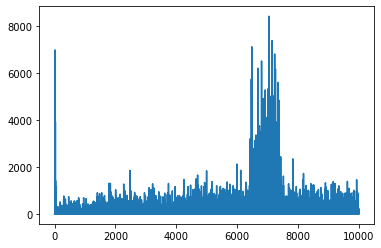

In [27]:
plt.plot(lpath)

What we see here is that at first the average path length increased. This is probably due to the fact that when we know nothing about the environment - we are likely to get trapped into bad states, water or wolf. As we learn more and start using this knowledge, we can explore the environment for longer, but we still do not know well where apples are.

Once we learn enough, it becomes easier for the agent to achieve the goal, and the path length starts to decrease. However, we are still open to exploration, so we often diverge away from the best path, and explore new options, making the path longer than optimal.

What we also observe on this graph, is that at some point the length increased abruptly. This indicates stochastic nature of the process, and that we can at some point "spoil" the Q-Table coefficients, by overwriting them with new values. This ideally should be minimized by decreasing learning rate (i.e. towards the end of training we only adjust Q-Table values by a small value).

Overall, it is important to remember that the success and quality of the learning process significantly depends on parameters, such as leaning rate, learning rate decay and discount factor. Those are often called **hyperparameters**, to distinguish them from **parameters** which we optimize during training (eg. Q-Table coefficients). The process of finding best hyperparameter values is called **hyperparameter optimization**, and it deserves a separate topic.

### Exercise
#### A More Realistic Peter and the Wolf World

In our situation, Peter was able to move around almost without getting tired or hungry. In a more realistic world, he has to sit down and rest from time to time, and also to feed himself. Let's make our world more realistic by implementing the following rules:

1. By moving from one place to another, Peter loses **energy** and gains some **fatigue**.
2. Peter can gain more energy by eating apples.
3. Peter can get rid of fatigue by resting under the tree or on the grass (i.e. walking into a board location with a tree or grass - green field)
4. Peter needs to find and kill the wolf
5. In order to kill the wolf, Peter needs to have certain levels of energy and fatigue, otherwise he loses the battle.

Modify the reward function above according to the rules of the game, run the reinforcement learning algorithm to learn the best strategy for winning the game, and compare the results of random walk with your algorithm in terms of number of games won and lost.


> **Note**: You may need to adjust hyperparameters to make it work, especially the number of epochs. Because the success of the game (fighting the wolf) is a rare event, you can expect much longer training time.



## Section 2

Let's implement the above exercise.

In [ ]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

![7](https://user-images.githubusercontent.com/62965911/224305190-e43db422-9e56-4df1-87e3-426fa30bbb49.png)

In [29]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

### Defining state

In our new game rules, we need to keep track of energy and fatigue at each board state. Thus we will create an object `state` that will carry all required information about current problem state, including state of the board, current levels of energy and fatigue, and whether we can win the wolf while at terminal state:

In [30]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Let's try to solve the problem using random walk and see if we succeed:

In [31]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [32]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


### Reward Function


In [33]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

### Q-Learning algorithm

The actual learning algorithm stays pretty much unchanged, we will use `state` instead of just board position.

In [34]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [35]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [36]:
from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

In [ ]:
m.plot(Q)

![8](https://user-images.githubusercontent.com/62965911/224305193-84aed922-a19f-4823-851f-409db6367b3e.png)

### Results

Let's see if we were successful training Peter to fight the wolf!

In [38]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


We now see much less cases of drowning, but Peter is still not always able to kill the wolf. Try to experiment and see if you can improve this result by playing with hyperparameters.

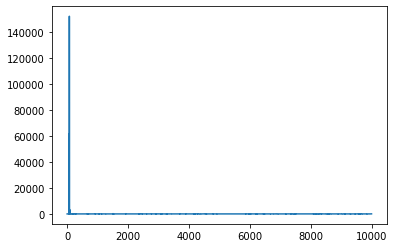

In [39]:
plt.plot(lpath)

## Section 3

In this section, we will apply the same principles of Q-Learning to a problem with continuous state, i.e. a state that is given by one or more real numbers. We will deal with the following problem:

Problem: If Peter wants to escape from the wolf, he needs to be able to move faster. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

![9](https://user-images.githubusercontent.com/62965911/224305197-80e43838-c7d1-4c02-996b-ea3bdd8604e2.png)

> Note: We will use a simplified version of balancing known as a CartPole problem. In the cartpole world, we have a horizontal slider that can move left or right, and the goal is to balance a vertical pole on top of the slider.

### OpenAI Gym
In previous sections, the rules of the game and the state were given by the Board class which we defined ourselves. Here we will use a special simulation environment, which will simulate the physics behind the balancing pole. One of the most popular simulation environments for training reinforcement learning algorithms is called a Gym, which is maintained by OpenAI. By using this gym we can create difference environments from a cartpole simulation to Atari games.

In [ ]:
!apt-get install -y xvfb x11-utils

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

!pip install gym

In [44]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

### CartPole Skating

> **Problem**: If Peter wants to escape from the wolf, he needs to be able to move faster than him. We will see how Peter can learn to skate, in particular, to keep balance, using Q-Learning.

First, let's install the gym and import required libraries:

In [45]:
import sys
import gym
import matplotlib.pyplot as plt
import numpy as np
import random

### Create a cartpole environment

In [46]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
1


In [ ]:
from IPython.display import Image
Image(open('images/cartpole-nobalance.gif','rb').read())

![10](https://user-images.githubusercontent.com/62965911/224305201-4fb37363-1cec-4599-a215-fcb6a164dfb6.png)

To see how the environment works, let's run a short simulation for 100 steps.

In [47]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


During simulation, we need to get observations in order to decide how to act. In fact, `step` function returns us back current observations, reward function, and the `done` flag that indicates whether it makes sense to continue the simulation or not:

In [48]:
env.reset()

done = False
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[ 0.00220021  0.22944733 -0.01140885 -0.26823641] -> 1.0
[ 0.00678916  0.03449004 -0.01677358  0.02082636] -> 1.0
[ 0.00747896 -0.16038739 -0.01635705  0.30817019] -> 1.0
[ 0.00427121 -0.3552725  -0.01019365  0.59564999] -> 1.0
[-0.00283424 -0.55025032  0.00171935  0.88510464] -> 1.0
[-0.01383925 -0.35515175  0.01942144  0.59296271] -> 1.0
[-0.02094228 -0.16030698  0.0312807   0.30646021] -> 1.0
[-0.02414842  0.03435559  0.0374099   0.02380424] -> 1.0
[-0.02346131 -0.16128233  0.03788599  0.32805174] -> 1.0
[-0.02668696 -0.35692259  0.04444702  0.63243736] -> 1.0
[-0.03382541 -0.55263553  0.05709577  0.93877995] -> 1.0
[-0.04487812 -0.74847881  0.07587137  1.24884322] -> 1.0
[-0.05984769 -0.55440705  0.10084823  0.98085784] -> 1.0
[-0.07093584 -0.36077073  0.12046539  0.72147828] -> 1.0
[-0.07815125 -0.55733493  0.13489496  1.04951899] -> 1.0
[-0.08929795 -0.36423521  0.15588534  0.80203969] -> 1.0
[-0.09658265 -0.17155524  0.17192613  0.56216916] -> 1.0
[-0.10001376 -0.36861978  0.183

We can get min and max value of those numbers:

In [49]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


### State Discretization

In [50]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

Let's also explore other discretization method using bins:

In [51]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


Let's now run a short simulation and observe those discrete environment values.

In [52]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, -1, -3)
(0, 1, -1, -6)
(0, 2, -3, -9)
(0, 3, -4, -12)
(0, 3, -7, -15)
(0, 4, -10, -18)
(0, 3, -14, -15)
(0, 4, -17, -19)
(0, 3, -21, -16)


### Q-Table Structure

In [53]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

### Let's Start Q-Learning!

In [54]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

In [55]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info = env.step(a)
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 36.0, alpha=0.3, epsilon=0.9
5000: 95.7114, alpha=0.3, epsilon=0.9
10000: 143.0132, alpha=0.3, epsilon=0.9
15000: 162.9334, alpha=0.3, epsilon=0.9
20000: 182.181, alpha=0.3, epsilon=0.9
25000: 193.3598, alpha=0.3, epsilon=0.9
30000: 213.3228, alpha=0.3, epsilon=0.9
35000: 223.3262, alpha=0.3, epsilon=0.9
40000: 238.8152, alpha=0.3, epsilon=0.9
45000: 247.5302, alpha=0.3, epsilon=0.9
50000: 275.7824, alpha=0.3, epsilon=0.9
55000: 281.1164, alpha=0.3, epsilon=0.9
60000: 307.8212, alpha=0.3, epsilon=0.9
65000: 293.3144, alpha=0.3, epsilon=0.9
70000: 302.5454, alpha=0.3, epsilon=0.9
75000: 294.7994, alpha=0.3, epsilon=0.9
80000: 296.515, alpha=0.3, epsilon=0.9
85000: 304.9482, alpha=0.3, epsilon=0.9
90000: 304.2536, alpha=0.3, epsilon=0.9
95000: 314.6624, alpha=0.3, epsilon=0.9


### Plotting Training Progress

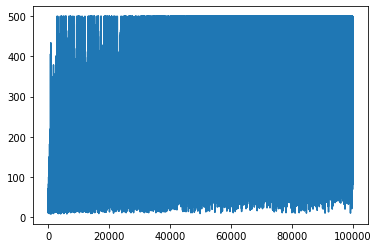

In [56]:
plt.plot(rewards)

From this graph, it is not possible to tell anything, because due to the nature of stochastic training process the length of training sessions varies greatly. To make more sense of this graph, we can calculate **running average** over series of experiments, let's say 100. This can be done conveniently using `np.convolve`:

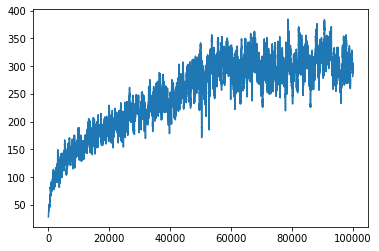

In [57]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

### Varying Hyperparameters and Seeing the Result in Action

Now it would be interesting to actually see how the trained model behaves. Let's run the simulation, and we will be following the same action selection strategy as during training: sampling according to the probability distribution in Q-Table: 

In [58]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
env.close()

### Saving result to an animated GIF

If you want to impress your friends, you may want to send them the animated GIF picture of the balancing pole. To do this, we can invoke `env.render` to produce an image frame, and then save those to animated GIF using PIL library:

In [59]:
from PIL import Image
obs = env.reset()
done = False
i=0
ims = []
while not done:
   s = discretize(obs)
   img=env.render(mode='rgb_array')
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

363


In [ ]:
from IPython.display import Image
Image(open('images/cartpole-balance.gif','rb').read())

![11](https://user-images.githubusercontent.com/62965911/224305202-b0f48ad3-71a5-4f56-88e9-3f7fb1cbb42e.png)